# KSA206: Polar Observations and Modelling

# Week 6 - Transport streamfunction

We have worked in previous classes with different types of variables, including velocities. If we know a velocity field, we can calculate the transport associated which will tell us how much *mass* or *volume* of water is going through a certain area in a given amount of time. This is useful to understand the strength of ocean currents.

One way of looking at transport is by using a streamfunction. Like velocity fields, transport is a vector that needs two directions to be defined, and so for a complete description of the circulation we would need a zonal and a meridional transport. A streamfunction combines these vectors into just one scalar field, making it very easy to calculate and visualize transports.

Mathematically, the streamfunction $\psi$ of a 2D transport field made by $T_x$ in the zonal direction and $T_y$ in the meridional direction is given by:

$$
T_x = -\frac{\partial \psi}{\partial y} \quad \quad T_y = \frac{\partial \psi}{\partial x}
$$

Remember that the right hand side of these expressions, like we saw when we calculated surface currents, is a gradient. In words, the mathematical expression is saying that the *change of $\psi$ with $x$ is related to the meridional transport, and the change of $\psi$ with y is related to the zonal transport*.

Drawing a parallel with what we saw for geostrophic currents and sea level, we can safely say that the currents will flow parallel to streamlines:

<div align="center",style="max-width: 500px;">
    <img src="images/stream_function_schematic.jpg" width="40%" />
</div>

The vectors represent the flow field, and the contours the streamfunction, with higher values in darker red.

## Calculation of the streamfunction

We can integrate the expressions above to calculate the streamfunction:

$$
\psi(x,y) = -\int_{y_i}^{y} T_x(x,y) dy \quad \quad \psi(x,y) = \int_{x_i}^{x} T_y(x,y) dx
$$

Technically, you would be able to obtain the streamfunction from either of these expressions. In oceanography we usually use the first expression, because we can start integrating from the Antarctic continent northwards and not have any issues at the boundaries. The second expression, integrating zonally, would generate a discontinuity at the zonally open Drake Passage.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Load data

Let's open the mean zonal and meridional transports from the ACCESS-OM2. We have a monthly climatology of these variables:

In [3]:
T = xr.open_dataset('data/access-om2_zonal_meridional_transports_iaf.nc')

In [4]:
T

<xarray.Dataset>
Dimensions:         (yt_ocean: 300, xu_ocean: 360, month: 12, xt_ocean: 360,
                     yu_ocean: 300)
Coordinates:
  * yt_ocean        (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
  * xu_ocean        (xu_ocean) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * xt_ocean        (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yu_ocean        (yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.1 89.55 90.0
Data variables:
    tx_trans_int_z  (month, yt_ocean, xu_ocean) float32 ...
    ty_trans_int_z  (month, yu_ocean, xt_ocean) float32 ...
Attributes:
    long_name:      T-cell i-mass transport vertically summed
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cy...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-03-03
    description:    Cycle 6/6 of 1 degree ACCESS-OM2-BGC global configuration...
    notes:          Output diagnostics are extensive based on the CMIP6 OMIP ...
    url:            https://github.com/hakaseh/1deg_jra55_iaf

You can see that the variable names here are `tx_trans_int_z` and `ty_trans_int_z`. The `trans` portion means transport, and the `int_z` means it is integrated in the vertical. So these are the *transports for the entire water column*. Note how their coordinates are different... but don't worry, we won't be bothered by this!

If you look at the attributes, you will see they are in units of kg/s, which means they are *mass* transports. We can convert to a *volume* transport simply by dividing by a reference density, 1035 kg/m$^3$, which will leave our transport in units of m$^3$/s:

In [5]:
T = T/1035

So, what does it mean that the units are in m$^3$/s? It means that the value at a certain gridcell is telling us how much water is going through it. This makes it easy for our integration, we just need to do a cumulative sum from south to north to get the streamfunction!

In [6]:
ψ = T['tx_trans_int_z'].cumsum('yt_ocean')

Let's plot and see what it looks like:

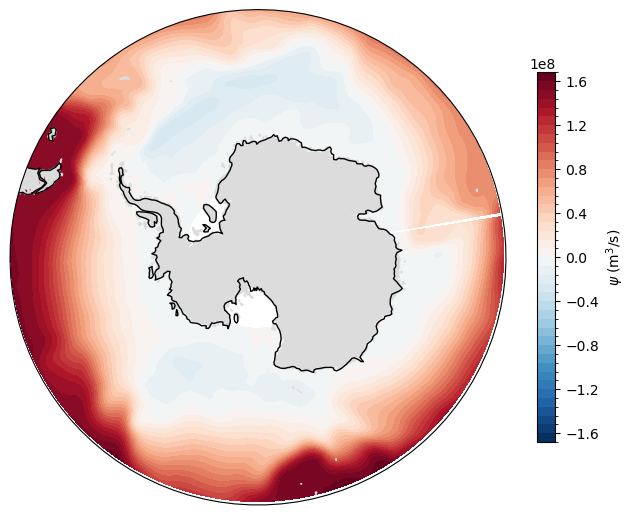

In [7]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
ψ.mean('month').sel(yt_ocean = slice(None, -50)).plot.contourf(levels = 50, transform = ccrs.PlateCarree(),
                                                               cbar_kwargs = {'label': '$\\psi$ (m$^3$/s)', 'shrink':.6});

If you look at the colorbar, you'll notice the values are quite high! Usually, oceanographers present transport in units of Sv, which is just 1 million $m^3/s$. Let's convert our streamfuntion to Sv units and plot again:

In [8]:
ψ = ψ / 1e6

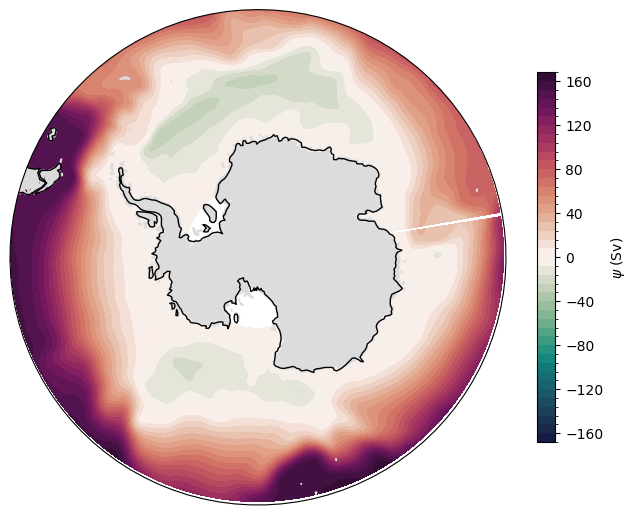

In [9]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
ψ.mean('month').sel(yt_ocean = slice(None, -50)).plot.contourf(levels = 50, transform = ccrs.PlateCarree(),
                                                               cmap = cm.cm.curl, cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':.6});

How is the streamfunction related to transport? **The transport between two streamlines is the difference in value between them**. Let's dig into that a bit deeper by plotting the streamfunction and vectors of $T_x$ and $T_y$ in a smaller area:

In [10]:
ψ_zoom = ψ.sel(yt_ocean = slice(-70, -50), xu_ocean = slice(-10, 10)).mean('month')
Tx_zoom = T['tx_trans_int_z'].sel(yt_ocean = slice(-70, -50), xu_ocean = slice(-10, 10)).mean('month')
Ty_zoom = T['ty_trans_int_z'].sel(yu_ocean = slice(-70, -50), xt_ocean = slice(-10, 10)).mean('month')

To plot them together let's interpolate to the same dimensions:

In [11]:
Ty_zoom = Ty_zoom.rename({'xt_ocean':'xu_ocean', 'yu_ocean':'yt_ocean'})
Ty_zoom = Ty_zoom.interp(xu_ocean = Tx_zoom['xu_ocean'], yt_ocean = Tx_zoom['yt_ocean'])

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jmneme\AppData\Local\Temp\ipykernel_18216\2697155457.py:2: SyntaxWarning: invalid escape sequence '\p'
  cbar_kwargs = {'label': '$\psi$ (Sv)'});


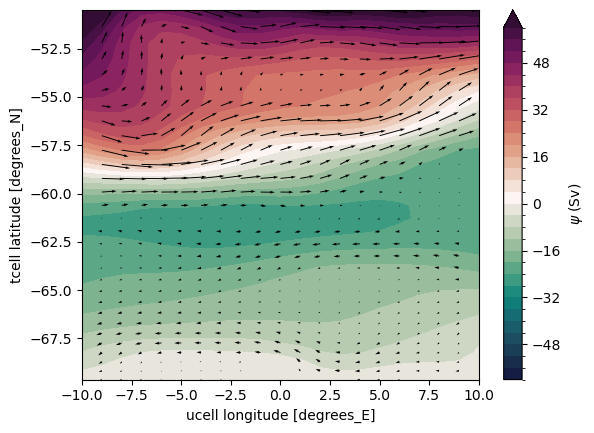

In [12]:
ψ_zoom.plot.contourf(levels = 31, vmin = -60, vmax = 60, cmap = cm.cm.curl, 
                       cbar_kwargs = {'label': '$\psi$ (Sv)'});
plt.quiver(Tx_zoom['xu_ocean'].values, Tx_zoom['yt_ocean'].values, Tx_zoom.values, Ty_zoom.values);

There's a couple of things to note in this figure:
- Regions with tight streamlines have largest transports. If you remember that $T_x = -\frac{\partial \psi}{\partial y}$, you can see that the largest the gradient in $\psi$, the largest the $T_x$. This is similar to what we saw when we where calculating surface geostrophic currents from satellite data.
- Regions of little change in the streamfunction have weak flow (related to the above point)
- The flow is parallel to the streamlines (again similar to surface geostrophic currents/sea level)
- We can infer the direction of the flow from the difference between subsequent streamfunctions

Let's further illustrate this last point:

<div align="center",style="max-width: 500px;">
    <img src="images/psi_diff.png" width="50%" />
</div>

If we grab the northermost point ($\psi_{triangle}$ and substract it from the southernmost point $\psi_{circle}$, we will get a difference that is negative, and so:

$$
\frac{\partial \psi}{\partial y} < 0
$$

therefore, the zonal transport between these points is negative, which means to the west. And we can verify that by looking at the arrows. 

<h4 style="color: red;">Question 1</h4>

Using the same logic, explain the direction of the transport between the diamond and the star.

*Answer here*

<h4 style="color: red;">Question 2</h4>

With this knowledge, coming back to the circumpolar map, explain what the circulation looks like from the streamfunction.

*Answer here*

## Calculating the strength of the Antarctic Circumpolar Current

We can use the streamfunction to calculate the total transport of the ACC. For this, we will take advantage of the fact that the Drake Passage acts as a bottleneck: at the Passage longitudes, all the ACC flows between South America and Antarctica, spreading out into a wider flow the rest at other locations. To illustrate this, let's plot the streamfunction at the Drake Passage:

In [13]:
ψ_dp = ψ.sel(yt_ocean = slice(-66, -49), xu_ocean = slice(-90,-50)).mean('month')
Tx_dp = T['tx_trans_int_z'].sel(yt_ocean = slice(-66, -49), xu_ocean = slice(-90, -50)).mean('month')
Ty_dp = T['ty_trans_int_z'].sel(yu_ocean = slice(-66, -49), xt_ocean = slice(-90, -50)).mean('month')

Ty_dp = Ty_dp.rename({'xt_ocean':'xu_ocean', 'yu_ocean':'yt_ocean'})
Ty_dp = Ty_dp.interp(xu_ocean = Tx_dp['xu_ocean'], yt_ocean = Tx_dp['yt_ocean'])

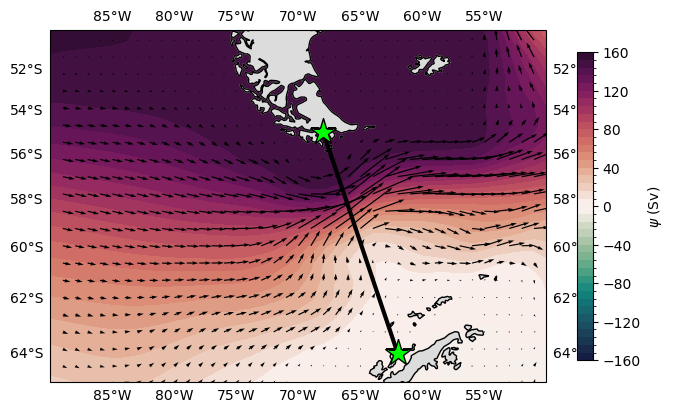

In [14]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.Mercator(central_longitude = -70))
ax.set_extent([-90, -50, -65, -50], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='gainsboro',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ψ_dp.plot.contourf(ax = ax, levels = 41, cmap = cm.cm.curl, transform = ccrs.PlateCarree(),
                   cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':0.5});
ax.quiver(Tx_dp['xu_ocean'].values, Tx_dp['yt_ocean'].values, Tx_dp.values, Ty_dp.values,
          transform = ccrs.PlateCarree());

ax.plot([-68, -62], [-55, -64], marker = '*', markersize = 20, markerfacecolor = 'lime', 
        color = 'k', linewidth = 3, transform = ccrs.PlateCarree());

To get the Drake Passage transport, we need to get the transport across the black line, which like we saw before is the difference in the value of the streamfunction at the star in South America, and the star at the tip of the Antarctic Peninsula:

In [15]:
ψ_south_america = ψ.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')

In [16]:
DP_transport = ψ_south_america - ψ_antarctic_pen

Let's plot it (remember we had a monthly climatology, so this will plot the seasonal cycle of the Drake Passage transport):

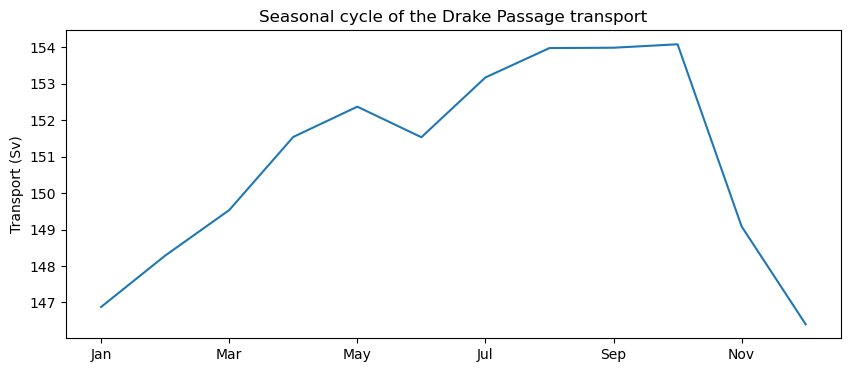

In [17]:
plt.figure(figsize = (10, 4))
plt.plot(DP_transport);
plt.ylabel('Transport (Sv)')
plt.xticks(np.arange(0,12,2), ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']);
plt.title('Seasonal cycle of the Drake Passage transport');

<h4 style="color: red;">Question 4</h4>

[Donohue et al. (2016)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL070319) estimated the mean Drake Passage transport to be 173.3 Sv. How does that compare to our estimate?

*Answer here*

## Weddell Gyre transport

The Weddell Gyre is a large, clockwise (cyclonic) circulation in the Weddell Sea. In our circumpolar map of the streamfunction, it is the green area to the east of the Antarctic Peninsula:

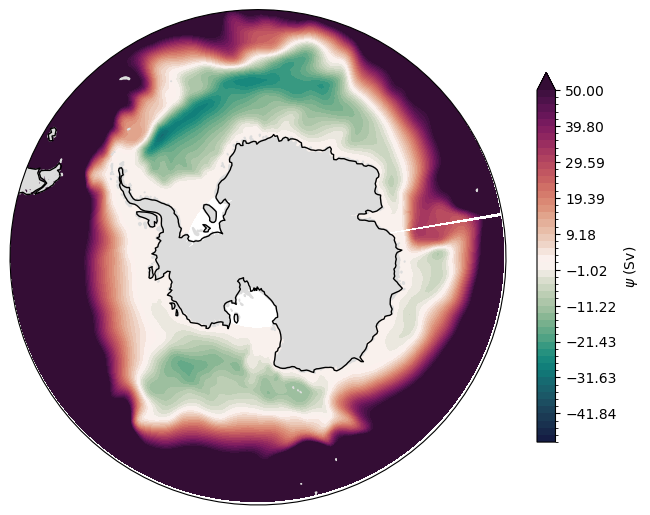

In [18]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
ψ.mean('month').sel(yt_ocean = slice(None, -50)).plot.contourf(levels = 50, vmin = -50, vmax = 50, transform = ccrs.PlateCarree(),
                                                               cmap = cm.cm.curl, cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':.6});

The method to calculate the strength of the Weddell Gyre will be similar to the Drake Passage, with a bit of extra work because this time the circulation is not bound by continents like in the DP, but free to move around and shift its location.

In [19]:
ψ_wg = ψ.sel(yt_ocean = slice(None, -50), xu_ocean = slice(-80, 70))

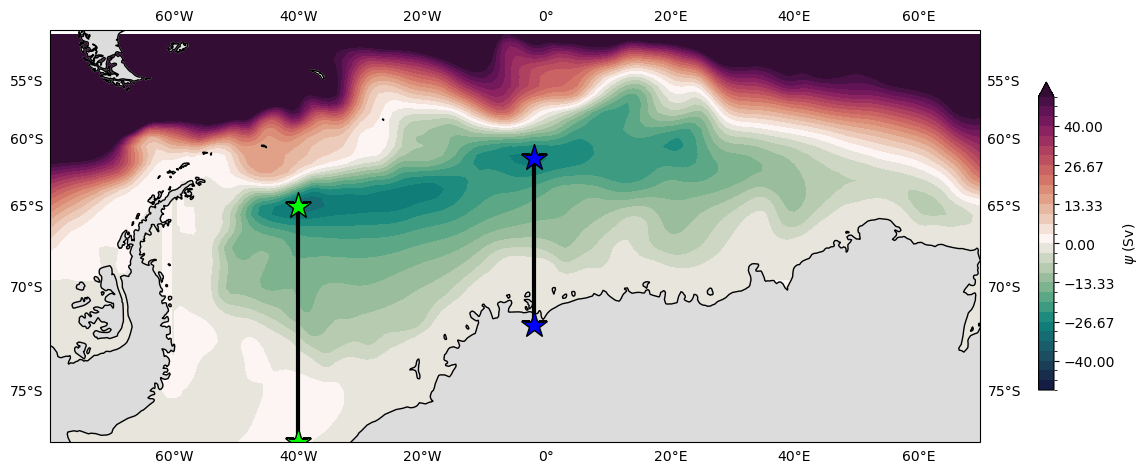

In [20]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(projection = ccrs.Mercator(central_longitude = 5))
ax.set_extent([-80, 70, -77, -50], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='gainsboro',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ψ_wg.mean('month').plot.contourf(ax = ax, levels = 31, vmin = -50, vmax = 50, cmap = cm.cm.curl, transform = ccrs.PlateCarree(),
                                 cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':0.5});

ax.plot([-40, -40], [-77, -65], marker = '*', markersize = 20, markerfacecolor = 'lime', 
        color = 'k', linewidth = 3, transform = ccrs.PlateCarree());
ax.plot([-2, -2], [-72, -61.5], marker = '*', markersize = 20, markerfacecolor = 'blue', 
        color = 'k', linewidth = 3, transform = ccrs.PlateCarree());

Remember that the flow leaves highest values of the streamfunction to the left. So, as we go from the Antarctic coastline north, as the values of $\psi$ decrease, we have a current going to the west. Once we reach the smallest value of the streamfunction, in the deepest greens, and continue going north, the streamfunction increases, and so we have a current current flowing towards the east. At either end of this map, there is a meridional flow closing the loop, forming what is known as a gyre. 

From the explanantion above, it is easy to see that, because it is a closed circulation, we would just need to calculate the transport between the Antarctic continent (**which is always zero!**) and the center of the gyre, which is the **smallest** value of $\psi$!

But, we need to make a choice: do we calculate the Weddell Gyre strength using the streamfunction difference between the green stars or between the blue stars?

In truth, none of these choices is strictly correct, because the gyre is free to change shape throughout time. For example, look at the figure below with $\psi$ for January and July:

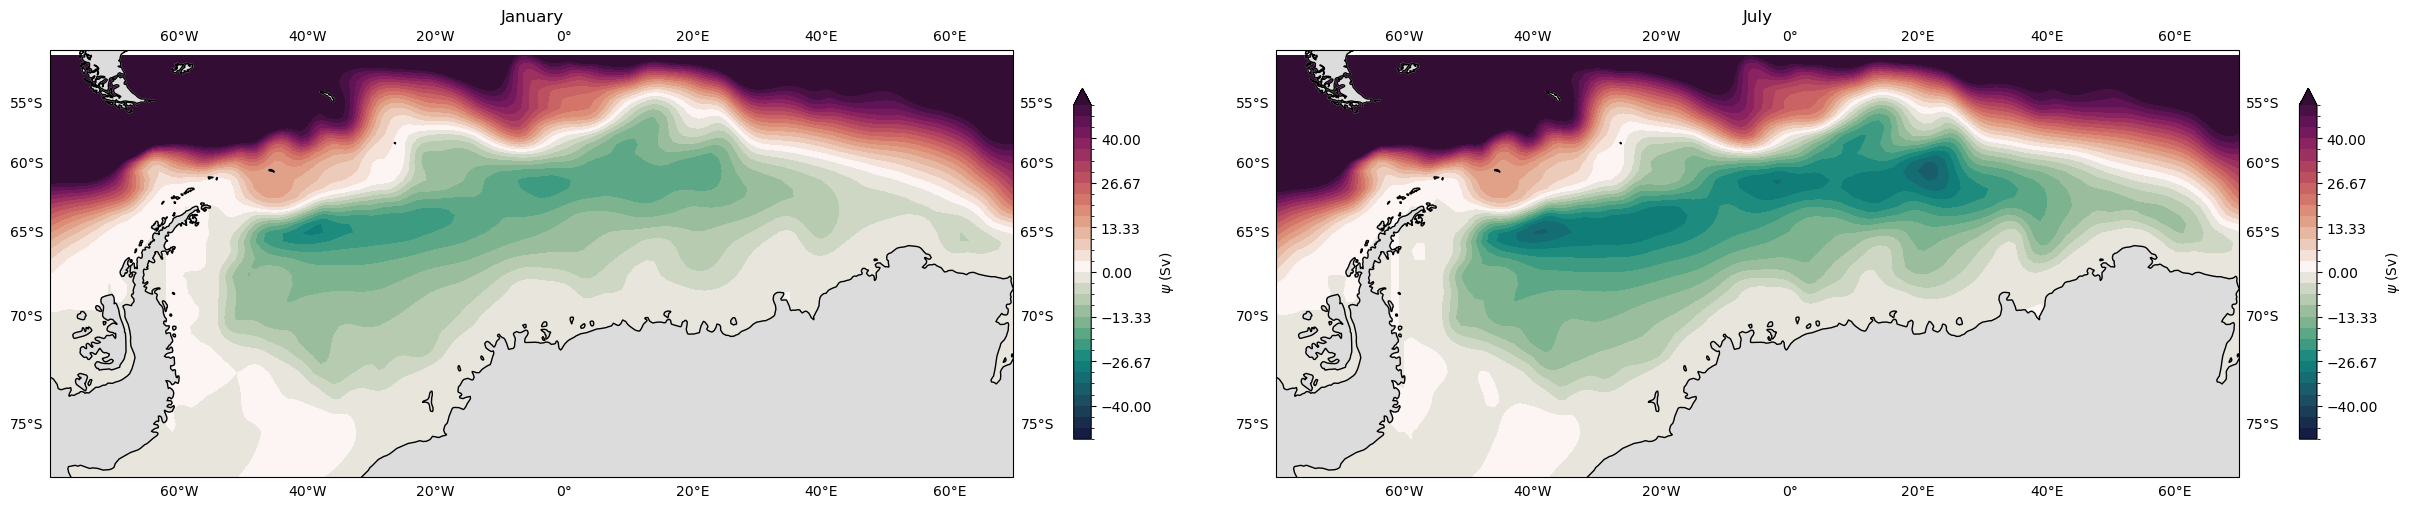

In [21]:
fig = plt.figure(figsize = (25, 12))
axs = [fig.add_subplot(121, projection = ccrs.Mercator(central_longitude = 5)),
       fig.add_subplot(122, projection = ccrs.Mercator(central_longitude = 5))]
for ax in axs:
    ax.set_extent([-80, 70, -77, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "50m")
    gl = ax.gridlines(draw_labels = True, linewidth = 0)
    gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
    gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ψ_wg.isel(month = 0).plot.contourf(ax = axs[0], levels = 31, vmin = -50, vmax = 50, cmap = cm.cm.curl, transform = ccrs.PlateCarree(),
                                   cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':0.3});
ψ_wg.isel(month = 6).plot.contourf(ax = axs[1], levels = 31, vmin = -50, vmax = 50, cmap = cm.cm.curl, transform = ccrs.PlateCarree(),
                                   cbar_kwargs = {'label': '$\\psi$ (Sv)', 'shrink':0.3});
axs[0].set_title('January'); axs[1].set_title('July');
plt.tight_layout();

So what we really need to do, is select the minimum value of $\psi$ at every time step. And that is it, because remember that the value of $\psi$ at any point of the continent is zero. 

In [22]:
weddell_transport = ψ_wg.min(['xu_ocean', 'yt_ocean'])

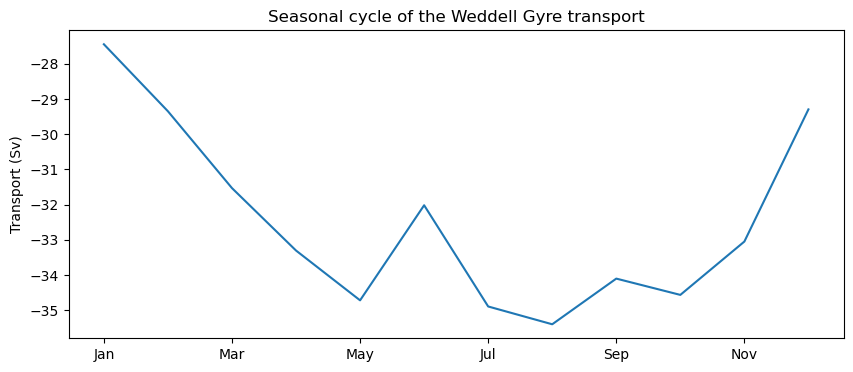

In [23]:
plt.figure(figsize = (10, 4))
plt.plot(weddell_transport);
plt.ylabel('Transport (Sv)')
plt.xticks(np.arange(0,12,2), ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']);
plt.title('Seasonal cycle of the Weddell Gyre transport');

It is negative because the streamfunction is negative, but we can flip it to make it more intuitive:

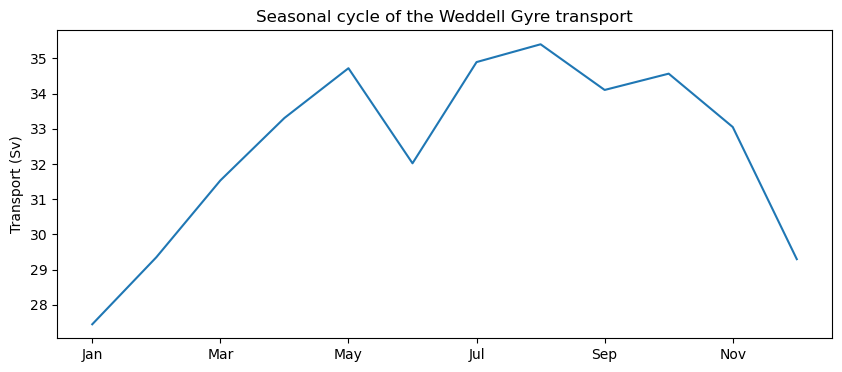

In [24]:
plt.figure(figsize = (10, 4))
plt.plot(-weddell_transport);
plt.ylabel('Transport (Sv)')
plt.xticks(np.arange(0,12,2), ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']);
plt.title('Seasonal cycle of the Weddell Gyre transport');

<h4 style="color: red;">Question 5</h4>

The Ross Gyre is the other subpolar gyre in the Southern Ocean, located in the Ross Sea. It is the other area of negative $\psi$ in our circumpolar map. Calculate the seasonal cycle in this gyre's transport.

*Answer here*